In [1]:
## import all the things
import numpy as np
import pandas as pd
from glob import glob
from os import environ
from root_pandas import read_root
# on Wisc machine, must be before Keras import
environ['KERAS_BACKEND'] = 'tensorflow'
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

Welcome to JupyROOT 6.14/00


Using TensorFlow backend.


In [3]:
## build the model
model = Sequential()
model.add(Dense(6, input_shape=(6,), name='input', activation='sigmoid'))
model.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
callbacks = [
            EarlyStopping(monitor='val_loss', patience=50),
        ]

In [33]:
input_variables = ['mjj', 'met', 'j1_pt', 'j2_pt'] ## will add lepton pT's as well
other_vars = [
    'evtwt', 'cat_inclusive', 'cat_0jet', 'cat_boosted', 'cat_vbf',
    'Dbkg_VBF', 'Dbkg_ggH', 'njets', 'higgs_pT', 't1_charge', 't1_pt'
]
el_slicer = input_variables + other_vars + ['nbjets', 'el_pt', 'el_charge', 'mt']
mu_slicer = input_variables + other_vars + ['nbtag', 'mu_pt', 'mu_charge', 'mt']
tt_slicer = input_variables + other_vars + ['nbtag', 't2_pt', 't2_charge']

In [34]:
el_sig_df = read_root('input_files/ggH125.root', columns=el_slicer)
el_bkg_df = read_root('input_files/ZTT.root', columns=el_slicer)
mu_sig_df = read_root('input_files/outputs_nominal_mt/ggH125.root', columns=mu_slicer)
mu_bkg_df = read_root('input_files/outputs_nominal_mt/ZTT.root', columns=mu_slicer)
tt_sig_df = read_root('input_files/outputs_nominal_tt/ggH125.root', columns=tt_slicer)
tt_bkg_df = read_root('input_files/outputs_nominal_tt/ZTT.root', columns=tt_slicer)

In [53]:
def el_selection(df):
    qual_cut = (df['njets'] > 1) & \
               (df['nbjets'] == 0) & (df['mjj'] < 600) & \
               (df['t1_pt'] > 30) & (df['mt'] < 50) & \
               (df['el_charge'] + df['t1_charge'] == 0)
    df = df[qual_cut]
    
    # make sure the weight is in the correct column and is normalized 
    weight = df['evtwt'].values
    from sklearn.preprocessing import MinMaxScaler
    points = weight.shape[0]
    weight = weight.reshape(-1, 1)
    weight = MinMaxScaler(feature_range=(0, 1)).fit_transform(weight)
    weight = weight.reshape(points, -1)
    df.insert(loc=df.shape[1], column='weight', value=weight)
    
    l1_pt = df['el_pt'].values
    l2_pt = df['t1_pt'].values
    df.insert(loc=0, column='l1_pt', value=l1_pt)
    df.insert(loc=0, column='l2_pt', value=l2_pt)
    
    # remove un-needed columns
    droppers = other_vars + ['nbjets', 'el_pt', 'el_charge', 'mt', 't1_pt']
    df = df.drop(droppers, axis=1)

    return df

In [81]:
def mu_selection(df):
    qual_cut = (df['njets'] > 1) & \
               (df['nbtag'] == 0) & (df['mjj'] < 600) & \
               (df['t1_pt'] > 40) & (df['mt'] < 50) & \
               (df['mu_charge'] + df['t1_charge'] == 0)
    df = df[qual_cut]
    
    # make sure the weight is in the correct column and is normalized 
    weight = df['evtwt'].values
    from sklearn.preprocessing import MinMaxScaler
    points = weight.shape[0]
    weight = weight.reshape(-1, 1)
    weight = MinMaxScaler(feature_range=(0, 1)).fit_transform(weight)
    weight = weight.reshape(points, -1)
    df.insert(loc=df.shape[1], column='weight', value=weight)

    l1_pt = df['mu_pt'].values
    l2_pt = df['t1_pt'].values
    df.insert(loc=0, column='l1_pt', value=l1_pt)
    df.insert(loc=0, column='l2_pt', value=l2_pt)

    # remove un-needed columns
    droppers = other_vars + ['nbtag', 'mu_pt', 'mu_charge', 'mt', 't1_pt']
    df = df.drop(droppers, axis=1)

    return df

In [82]:
def tt_selection(df):
    qual_cut = (df['njets'] > 1) & \
               (df['nbtag'] == 0) & (df['mjj'] < 600) & \
               (df['t1_charge'] + df['t2_charge'] == 0)
    df = df[qual_cut]
    
    # make sure the weight is in the correct column and is normalized 
    weight = df['evtwt'].values
    from sklearn.preprocessing import MinMaxScaler
    points = weight.shape[0]
    weight = weight.reshape(-1, 1)
    weight = MinMaxScaler(feature_range=(0, 1)).fit_transform(weight)
    weight = weight.reshape(points, -1)
    df.insert(loc=df.shape[1], column='weight', value=weight)

    l1_pt = df['t1_pt'].values
    l2_pt = df['t2_pt'].values
    df.insert(loc=0, column='l1_pt', value=l1_pt)
    df.insert(loc=0, column='l2_pt', value=l2_pt)
    
    # remove un-needed columns
    droppers = other_vars + ['nbtag', 't2_pt', 't1_charge', 't2_charge', 't1_pt']
    df = df.drop(droppers, axis=1)

    return df

In [88]:
el_sig_df = el_selection(el_sig_df)
el_bkg_df = el_selection(el_bkg_df)
mu_sig_df = mu_selection(mu_sig_df)
mu_bkg_df = mu_selection(mu_bkg_df)
tt_sig_df = tt_selection(tt_sig_df)
tt_bkg_df = tt_selection(tt_bkg_df)

In [93]:
signal = pd.concat([el_sig_df, mu_sig_df, tt_sig_df], sort=False)
background = pd.concat([el_bkg_df, mu_bkg_df, tt_bkg_df], sort=False)

In [106]:
signal['isSignal'] = np.ones(len(signal))
background['isSignal'] = np.zeros(len(background))
tt_bkg_df['isSignal'] = np.zeros(len(tt_bkg_df))

In [107]:
print 'No. Signal {}'.format(len(signal))
print 'No. Background {}'.format(len(background))

No. Signal 4300
No. Background 100236


In [112]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## make the combined dataset
# fat_panda = pd.concat([signal, background])
fat_panda = pd.concat([signal, tt_bkg_df], sort=False)
all_data = fat_panda.values ## convert pandas dataframe -> numpy array

In [113]:
# split data into labels and also split into train/test
data_train, data_test, meta_train, meta_test = train_test_split(
    all_data[:, :6], all_data[:, 6:], test_size=0.05, random_state=7)

In [114]:
# normalize all input variables to improve performance
data_train = StandardScaler().fit_transform(data_train)

In [115]:
## separate the event weights and labels
data = data_train
weight = meta_train[:, 0]
label = meta_train[:, 1]

In [116]:
model.fit(data, label, shuffle=True,
          epochs=10000, batch_size=1024, verbose=True,
          callbacks=callbacks, validation_split=0.25, sample_weight=weight
          )

Train on 8223 samples, validate on 2741 samples
Epoch 1/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.4867 - acc: 0.6264 - val_loss: 0.4773 - val_acc: 0.6242
Epoch 2/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.4497 - acc: 0.6264 - val_loss: 0.4386 - val_acc: 0.6242
Epoch 3/10000
8223/8223 [==============================] - 0s 3us/step - loss: 0.4125 - acc: 0.6262 - val_loss: 0.4039 - val_acc: 0.6242
Epoch 4/10000
8223/8223 [==============================] - 0s 4us/step - loss: 0.3804 - acc: 0.6257 - val_loss: 0.3751 - val_acc: 0.6242
Epoch 5/10000
8223/8223 [==============================] - 0s 4us/step - loss: 0.3540 - acc: 0.6246 - val_loss: 0.3510 - val_acc: 0.6228
Epoch 6/10000
8223/8223 [==============================] - 0s 3us/step - loss: 0.3326 - acc: 0.6250 - val_loss: 0.3315 - val_acc: 0.6220
Epoch 7/10000
8223/8223 [==============================] - 0s 3us/step - loss: 0.3152 - acc: 0.6239 - val_loss: 0.3154 - val_acc: 

8223/8223 [==============================] - 0s 3us/step - loss: 0.2129 - acc: 0.6509 - val_loss: 0.2122 - val_acc: 0.6337
Epoch 61/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.2127 - acc: 0.6510 - val_loss: 0.2119 - val_acc: 0.6355
Epoch 62/10000
8223/8223 [==============================] - 0s 3us/step - loss: 0.2124 - acc: 0.6513 - val_loss: 0.2116 - val_acc: 0.6374
Epoch 63/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.2122 - acc: 0.6526 - val_loss: 0.2113 - val_acc: 0.6406
Epoch 64/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.2120 - acc: 0.6556 - val_loss: 0.2111 - val_acc: 0.6432
Epoch 65/10000
8223/8223 [==============================] - 0s 3us/step - loss: 0.2117 - acc: 0.6610 - val_loss: 0.2109 - val_acc: 0.6483
Epoch 66/10000
8223/8223 [==============================] - 0s 3us/step - loss: 0.2115 - acc: 0.6652 - val_loss: 0.2107 - val_acc: 0.6512
Epoch 67/10000
8223/8223 [=======================

8223/8223 [==============================] - 0s 2us/step - loss: 0.2038 - acc: 0.7118 - val_loss: 0.2021 - val_acc: 0.6968
Epoch 120/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.2036 - acc: 0.7128 - val_loss: 0.2020 - val_acc: 0.6968
Epoch 121/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.2035 - acc: 0.7121 - val_loss: 0.2019 - val_acc: 0.6983
Epoch 122/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.2034 - acc: 0.7130 - val_loss: 0.2018 - val_acc: 0.6979
Epoch 123/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.2033 - acc: 0.7128 - val_loss: 0.2017 - val_acc: 0.6961
Epoch 124/10000
8223/8223 [==============================] - 0s 3us/step - loss: 0.2032 - acc: 0.7129 - val_loss: 0.2015 - val_acc: 0.6965
Epoch 125/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.2031 - acc: 0.7126 - val_loss: 0.2014 - val_acc: 0.6961
Epoch 126/10000
8223/8223 [================

8223/8223 [==============================] - 0s 2us/step - loss: 0.1982 - acc: 0.7351 - val_loss: 0.1966 - val_acc: 0.7209
Epoch 179/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1982 - acc: 0.7350 - val_loss: 0.1965 - val_acc: 0.7224
Epoch 180/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1981 - acc: 0.7354 - val_loss: 0.1964 - val_acc: 0.7231
Epoch 181/10000
8223/8223 [==============================] - 0s 3us/step - loss: 0.1980 - acc: 0.7359 - val_loss: 0.1964 - val_acc: 0.7220
Epoch 182/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1979 - acc: 0.7372 - val_loss: 0.1963 - val_acc: 0.7235
Epoch 183/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1978 - acc: 0.7374 - val_loss: 0.1962 - val_acc: 0.7242
Epoch 184/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1977 - acc: 0.7371 - val_loss: 0.1961 - val_acc: 0.7253
Epoch 185/10000
8223/8223 [================

8223/8223 [==============================] - 0s 3us/step - loss: 0.1937 - acc: 0.7509 - val_loss: 0.1921 - val_acc: 0.7479
Epoch 238/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1937 - acc: 0.7518 - val_loss: 0.1920 - val_acc: 0.7475
Epoch 239/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1936 - acc: 0.7514 - val_loss: 0.1919 - val_acc: 0.7475
Epoch 240/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1935 - acc: 0.7508 - val_loss: 0.1918 - val_acc: 0.7479
Epoch 241/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1935 - acc: 0.7507 - val_loss: 0.1918 - val_acc: 0.7468
Epoch 242/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1934 - acc: 0.7497 - val_loss: 0.1917 - val_acc: 0.7461
Epoch 243/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1933 - acc: 0.7486 - val_loss: 0.1916 - val_acc: 0.7461
Epoch 244/10000
8223/8223 [================

8223/8223 [==============================] - 0s 2us/step - loss: 0.1900 - acc: 0.7664 - val_loss: 0.1884 - val_acc: 0.7581
Epoch 297/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1900 - acc: 0.7675 - val_loss: 0.1884 - val_acc: 0.7581
Epoch 298/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1899 - acc: 0.7677 - val_loss: 0.1883 - val_acc: 0.7570
Epoch 299/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1898 - acc: 0.7678 - val_loss: 0.1882 - val_acc: 0.7578
Epoch 300/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1898 - acc: 0.7657 - val_loss: 0.1881 - val_acc: 0.7563
Epoch 301/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1897 - acc: 0.7649 - val_loss: 0.1881 - val_acc: 0.7563
Epoch 302/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1897 - acc: 0.7668 - val_loss: 0.1880 - val_acc: 0.7563
Epoch 303/10000
8223/8223 [================

8223/8223 [==============================] - 0s 2us/step - loss: 0.1870 - acc: 0.7803 - val_loss: 0.1855 - val_acc: 0.7713
Epoch 356/10000
8223/8223 [==============================] - 0s 3us/step - loss: 0.1870 - acc: 0.7801 - val_loss: 0.1855 - val_acc: 0.7716
Epoch 357/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1869 - acc: 0.7798 - val_loss: 0.1854 - val_acc: 0.7713
Epoch 358/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1869 - acc: 0.7794 - val_loss: 0.1854 - val_acc: 0.7713
Epoch 359/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1869 - acc: 0.7792 - val_loss: 0.1853 - val_acc: 0.7713
Epoch 360/10000
8223/8223 [==============================] - 0s 3us/step - loss: 0.1868 - acc: 0.7787 - val_loss: 0.1853 - val_acc: 0.7713
Epoch 361/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1868 - acc: 0.7785 - val_loss: 0.1852 - val_acc: 0.7709
Epoch 362/10000
8223/8223 [================

Epoch 414/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1847 - acc: 0.7851 - val_loss: 0.1832 - val_acc: 0.7749
Epoch 415/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1847 - acc: 0.7849 - val_loss: 0.1831 - val_acc: 0.7745
Epoch 416/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1847 - acc: 0.7844 - val_loss: 0.1831 - val_acc: 0.7749
Epoch 417/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1846 - acc: 0.7838 - val_loss: 0.1831 - val_acc: 0.7749
Epoch 418/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1846 - acc: 0.7837 - val_loss: 0.1830 - val_acc: 0.7745
Epoch 419/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1846 - acc: 0.7840 - val_loss: 0.1830 - val_acc: 0.7745
Epoch 420/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1845 - acc: 0.7843 - val_loss: 0.1830 - val_acc: 0.7753
Epoch 421/10000
8223/8223 [

Epoch 473/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1828 - acc: 0.7892 - val_loss: 0.1813 - val_acc: 0.7782
Epoch 474/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1828 - acc: 0.7895 - val_loss: 0.1813 - val_acc: 0.7778
Epoch 475/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1828 - acc: 0.7895 - val_loss: 0.1812 - val_acc: 0.7775
Epoch 476/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1827 - acc: 0.7896 - val_loss: 0.1812 - val_acc: 0.7785
Epoch 477/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1827 - acc: 0.7906 - val_loss: 0.1812 - val_acc: 0.7796
Epoch 478/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1827 - acc: 0.7917 - val_loss: 0.1812 - val_acc: 0.7793
Epoch 479/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1826 - acc: 0.7916 - val_loss: 0.1811 - val_acc: 0.7796
Epoch 480/10000
8223/8223 [

8223/8223 [==============================] - 0s 2us/step - loss: 0.1812 - acc: 0.7972 - val_loss: 0.1800 - val_acc: 0.7851
Epoch 532/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1812 - acc: 0.7976 - val_loss: 0.1800 - val_acc: 0.7855
Epoch 533/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1812 - acc: 0.7981 - val_loss: 0.1800 - val_acc: 0.7862
Epoch 534/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1812 - acc: 0.7982 - val_loss: 0.1799 - val_acc: 0.7851
Epoch 535/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1811 - acc: 0.7972 - val_loss: 0.1799 - val_acc: 0.7826
Epoch 536/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1811 - acc: 0.7961 - val_loss: 0.1798 - val_acc: 0.7829
Epoch 537/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1811 - acc: 0.7961 - val_loss: 0.1798 - val_acc: 0.7829
Epoch 538/10000
8223/8223 [================

8223/8223 [==============================] - 0s 2us/step - loss: 0.1798 - acc: 0.7989 - val_loss: 0.1786 - val_acc: 0.7862
Epoch 591/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1797 - acc: 0.7989 - val_loss: 0.1786 - val_acc: 0.7869
Epoch 592/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1797 - acc: 0.7986 - val_loss: 0.1786 - val_acc: 0.7866
Epoch 593/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1797 - acc: 0.7984 - val_loss: 0.1785 - val_acc: 0.7858
Epoch 594/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1797 - acc: 0.7980 - val_loss: 0.1785 - val_acc: 0.7855
Epoch 595/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1796 - acc: 0.7985 - val_loss: 0.1785 - val_acc: 0.7858
Epoch 596/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1796 - acc: 0.7990 - val_loss: 0.1785 - val_acc: 0.7858
Epoch 597/10000
8223/8223 [================

8223/8223 [==============================] - 0s 2us/step - loss: 0.1784 - acc: 0.8021 - val_loss: 0.1776 - val_acc: 0.7928
Epoch 650/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1784 - acc: 0.8018 - val_loss: 0.1776 - val_acc: 0.7924
Epoch 651/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1784 - acc: 0.8012 - val_loss: 0.1775 - val_acc: 0.7917
Epoch 652/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1783 - acc: 0.8010 - val_loss: 0.1775 - val_acc: 0.7910
Epoch 653/10000
8223/8223 [==============================] - 0s 3us/step - loss: 0.1783 - acc: 0.8007 - val_loss: 0.1775 - val_acc: 0.7888
Epoch 654/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1783 - acc: 0.7996 - val_loss: 0.1775 - val_acc: 0.7869
Epoch 655/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1783 - acc: 0.7997 - val_loss: 0.1774 - val_acc: 0.7869
Epoch 656/10000
8223/8223 [================

8223/8223 [==============================] - 0s 2us/step - loss: 0.1772 - acc: 0.8014 - val_loss: 0.1767 - val_acc: 0.7906
Epoch 709/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1772 - acc: 0.8020 - val_loss: 0.1768 - val_acc: 0.7931
Epoch 710/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1772 - acc: 0.8023 - val_loss: 0.1767 - val_acc: 0.7942
Epoch 711/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1771 - acc: 0.8030 - val_loss: 0.1767 - val_acc: 0.7935
Epoch 712/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1771 - acc: 0.8026 - val_loss: 0.1767 - val_acc: 0.7939
Epoch 713/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1771 - acc: 0.8031 - val_loss: 0.1767 - val_acc: 0.7942
Epoch 714/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1771 - acc: 0.8027 - val_loss: 0.1767 - val_acc: 0.7935
Epoch 715/10000
8223/8223 [================

Epoch 767/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1761 - acc: 0.8047 - val_loss: 0.1760 - val_acc: 0.7979
Epoch 768/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1761 - acc: 0.8046 - val_loss: 0.1759 - val_acc: 0.7982
Epoch 769/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1761 - acc: 0.8048 - val_loss: 0.1759 - val_acc: 0.7982
Epoch 770/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1760 - acc: 0.8042 - val_loss: 0.1759 - val_acc: 0.7979
Epoch 771/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1760 - acc: 0.8038 - val_loss: 0.1758 - val_acc: 0.7957
Epoch 772/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1760 - acc: 0.8034 - val_loss: 0.1758 - val_acc: 0.7946
Epoch 773/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1760 - acc: 0.8026 - val_loss: 0.1758 - val_acc: 0.7957
Epoch 774/10000
8223/8223 [

Epoch 826/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1751 - acc: 0.8036 - val_loss: 0.1752 - val_acc: 0.7982
Epoch 827/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1751 - acc: 0.8048 - val_loss: 0.1752 - val_acc: 0.7982
Epoch 828/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1751 - acc: 0.8059 - val_loss: 0.1752 - val_acc: 0.7990
Epoch 829/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1751 - acc: 0.8059 - val_loss: 0.1752 - val_acc: 0.7986
Epoch 830/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1751 - acc: 0.8052 - val_loss: 0.1751 - val_acc: 0.7975
Epoch 831/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1750 - acc: 0.8038 - val_loss: 0.1751 - val_acc: 0.7964
Epoch 832/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1750 - acc: 0.8037 - val_loss: 0.1751 - val_acc: 0.7968
Epoch 833/10000
8223/8223 [

Epoch 885/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1743 - acc: 0.8059 - val_loss: 0.1746 - val_acc: 0.7975
Epoch 886/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1743 - acc: 0.8047 - val_loss: 0.1746 - val_acc: 0.7961
Epoch 887/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1743 - acc: 0.8045 - val_loss: 0.1745 - val_acc: 0.7961
Epoch 888/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1743 - acc: 0.8045 - val_loss: 0.1745 - val_acc: 0.7964
Epoch 889/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1742 - acc: 0.8048 - val_loss: 0.1745 - val_acc: 0.7982
Epoch 890/10000
8223/8223 [==============================] - 0s 3us/step - loss: 0.1742 - acc: 0.8058 - val_loss: 0.1745 - val_acc: 0.7990
Epoch 891/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1742 - acc: 0.8060 - val_loss: 0.1745 - val_acc: 0.7990
Epoch 892/10000
8223/8223 [

Epoch 944/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1735 - acc: 0.8037 - val_loss: 0.1741 - val_acc: 0.7953
Epoch 945/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1735 - acc: 0.8036 - val_loss: 0.1741 - val_acc: 0.7957
Epoch 946/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1735 - acc: 0.8043 - val_loss: 0.1741 - val_acc: 0.7961
Epoch 947/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1735 - acc: 0.8058 - val_loss: 0.1740 - val_acc: 0.7968
Epoch 948/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1735 - acc: 0.8063 - val_loss: 0.1740 - val_acc: 0.7990
Epoch 949/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1734 - acc: 0.8062 - val_loss: 0.1740 - val_acc: 0.7986
Epoch 950/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1734 - acc: 0.8068 - val_loss: 0.1740 - val_acc: 0.7990
Epoch 951/10000
8223/8223 [

Epoch 1003/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1728 - acc: 0.8070 - val_loss: 0.1735 - val_acc: 0.8001
Epoch 1004/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1727 - acc: 0.8069 - val_loss: 0.1735 - val_acc: 0.8001
Epoch 1005/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1727 - acc: 0.8076 - val_loss: 0.1735 - val_acc: 0.8004
Epoch 1006/10000
8223/8223 [==============================] - 0s 3us/step - loss: 0.1727 - acc: 0.8072 - val_loss: 0.1735 - val_acc: 0.8012
Epoch 1007/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1727 - acc: 0.8076 - val_loss: 0.1735 - val_acc: 0.8001
Epoch 1008/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1727 - acc: 0.8082 - val_loss: 0.1735 - val_acc: 0.8001
Epoch 1009/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1727 - acc: 0.8079 - val_loss: 0.1735 - val_acc: 0.8008
Epoch 1010/10000
822

8223/8223 [==============================] - 0s 2us/step - loss: 0.1721 - acc: 0.8096 - val_loss: 0.1730 - val_acc: 0.8008
Epoch 1062/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1720 - acc: 0.8096 - val_loss: 0.1729 - val_acc: 0.8008
Epoch 1063/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1720 - acc: 0.8081 - val_loss: 0.1728 - val_acc: 0.7993
Epoch 1064/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1720 - acc: 0.8079 - val_loss: 0.1728 - val_acc: 0.7986
Epoch 1065/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1720 - acc: 0.8074 - val_loss: 0.1728 - val_acc: 0.7979
Epoch 1066/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1720 - acc: 0.8062 - val_loss: 0.1728 - val_acc: 0.7946
Epoch 1067/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1721 - acc: 0.8055 - val_loss: 0.1728 - val_acc: 0.7942
Epoch 1068/10000
8223/8223 [=========

8223/8223 [==============================] - 0s 2us/step - loss: 0.1714 - acc: 0.8096 - val_loss: 0.1725 - val_acc: 0.7993
Epoch 1120/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1714 - acc: 0.8103 - val_loss: 0.1725 - val_acc: 0.7986
Epoch 1121/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1714 - acc: 0.8098 - val_loss: 0.1725 - val_acc: 0.7990
Epoch 1122/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1713 - acc: 0.8103 - val_loss: 0.1725 - val_acc: 0.7993
Epoch 1123/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1713 - acc: 0.8104 - val_loss: 0.1725 - val_acc: 0.8001
Epoch 1124/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1713 - acc: 0.8113 - val_loss: 0.1725 - val_acc: 0.8001
Epoch 1125/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1713 - acc: 0.8105 - val_loss: 0.1724 - val_acc: 0.7990
Epoch 1126/10000
8223/8223 [=========

8223/8223 [==============================] - 0s 2us/step - loss: 0.1707 - acc: 0.8120 - val_loss: 0.1721 - val_acc: 0.8008
Epoch 1178/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1707 - acc: 0.8121 - val_loss: 0.1721 - val_acc: 0.8008
Epoch 1179/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1707 - acc: 0.8126 - val_loss: 0.1721 - val_acc: 0.8012
Epoch 1180/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1707 - acc: 0.8125 - val_loss: 0.1720 - val_acc: 0.8004
Epoch 1181/10000
8223/8223 [==============================] - 0s 3us/step - loss: 0.1707 - acc: 0.8124 - val_loss: 0.1720 - val_acc: 0.8004
Epoch 1182/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1707 - acc: 0.8126 - val_loss: 0.1720 - val_acc: 0.8008
Epoch 1183/10000
8223/8223 [==============================] - ETA: 0s - loss: 0.1694 - acc: 0.808 - 0s 2us/step - loss: 0.1707 - acc: 0.8126 - val_loss: 0.1720 - val_acc: 0.7990

8223/8223 [==============================] - 0s 2us/step - loss: 0.1701 - acc: 0.8116 - val_loss: 0.1714 - val_acc: 0.8023
Epoch 1236/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1700 - acc: 0.8126 - val_loss: 0.1714 - val_acc: 0.8034
Epoch 1237/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1700 - acc: 0.8128 - val_loss: 0.1714 - val_acc: 0.8030
Epoch 1238/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1700 - acc: 0.8136 - val_loss: 0.1714 - val_acc: 0.8030
Epoch 1239/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1700 - acc: 0.8133 - val_loss: 0.1714 - val_acc: 0.8030
Epoch 1240/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1700 - acc: 0.8127 - val_loss: 0.1714 - val_acc: 0.8023
Epoch 1241/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1700 - acc: 0.8135 - val_loss: 0.1714 - val_acc: 0.8023
Epoch 1242/10000
8223/8223 [=========

8223/8223 [==============================] - 0s 2us/step - loss: 0.1694 - acc: 0.8097 - val_loss: 0.1710 - val_acc: 0.8015
Epoch 1294/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1694 - acc: 0.8099 - val_loss: 0.1710 - val_acc: 0.8012
Epoch 1295/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1693 - acc: 0.8108 - val_loss: 0.1710 - val_acc: 0.8008
Epoch 1296/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1693 - acc: 0.8105 - val_loss: 0.1710 - val_acc: 0.8008
Epoch 1297/10000
8223/8223 [==============================] - ETA: 0s - loss: 0.1685 - acc: 0.805 - 0s 2us/step - loss: 0.1693 - acc: 0.8105 - val_loss: 0.1710 - val_acc: 0.7997
Epoch 1298/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1693 - acc: 0.8097 - val_loss: 0.1709 - val_acc: 0.7993
Epoch 1299/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1693 - acc: 0.8100 - val_loss: 0.1710 - val_acc: 0.8008

8223/8223 [==============================] - 0s 2us/step - loss: 0.1687 - acc: 0.8150 - val_loss: 0.1706 - val_acc: 0.8019
Epoch 1352/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1687 - acc: 0.8152 - val_loss: 0.1706 - val_acc: 0.8019
Epoch 1353/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1687 - acc: 0.8154 - val_loss: 0.1706 - val_acc: 0.8008
Epoch 1354/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1687 - acc: 0.8155 - val_loss: 0.1706 - val_acc: 0.8015
Epoch 1355/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1686 - acc: 0.8149 - val_loss: 0.1705 - val_acc: 0.8012
Epoch 1356/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1686 - acc: 0.8149 - val_loss: 0.1705 - val_acc: 0.8015
Epoch 1357/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1686 - acc: 0.8153 - val_loss: 0.1705 - val_acc: 0.8008
Epoch 1358/10000
8223/8223 [=========

8223/8223 [==============================] - 0s 2us/step - loss: 0.1681 - acc: 0.8210 - val_loss: 0.1702 - val_acc: 0.8055
Epoch 1410/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1681 - acc: 0.8199 - val_loss: 0.1701 - val_acc: 0.8037
Epoch 1411/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1680 - acc: 0.8190 - val_loss: 0.1701 - val_acc: 0.8041
Epoch 1412/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1680 - acc: 0.8193 - val_loss: 0.1701 - val_acc: 0.8045
Epoch 1413/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1680 - acc: 0.8192 - val_loss: 0.1700 - val_acc: 0.8037
Epoch 1414/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1680 - acc: 0.8182 - val_loss: 0.1700 - val_acc: 0.8034
Epoch 1415/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1680 - acc: 0.8173 - val_loss: 0.1700 - val_acc: 0.8034
Epoch 1416/10000
8223/8223 [=========

8223/8223 [==============================] - 0s 2us/step - loss: 0.1674 - acc: 0.8147 - val_loss: 0.1695 - val_acc: 0.8015
Epoch 1468/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1674 - acc: 0.8149 - val_loss: 0.1695 - val_acc: 0.8012
Epoch 1469/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1674 - acc: 0.8152 - val_loss: 0.1695 - val_acc: 0.8015
Epoch 1470/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1674 - acc: 0.8149 - val_loss: 0.1695 - val_acc: 0.8012
Epoch 1471/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1674 - acc: 0.8149 - val_loss: 0.1695 - val_acc: 0.8012
Epoch 1472/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1674 - acc: 0.8154 - val_loss: 0.1695 - val_acc: 0.8019
Epoch 1473/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1674 - acc: 0.8155 - val_loss: 0.1694 - val_acc: 0.8023
Epoch 1474/10000
8223/8223 [=========

8223/8223 [==============================] - 0s 2us/step - loss: 0.1669 - acc: 0.8171 - val_loss: 0.1690 - val_acc: 0.8037
Epoch 1526/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1669 - acc: 0.8179 - val_loss: 0.1690 - val_acc: 0.8041
Epoch 1527/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1669 - acc: 0.8173 - val_loss: 0.1690 - val_acc: 0.8041
Epoch 1528/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1669 - acc: 0.8150 - val_loss: 0.1690 - val_acc: 0.8045
Epoch 1529/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1669 - acc: 0.8148 - val_loss: 0.1690 - val_acc: 0.8037
Epoch 1530/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1669 - acc: 0.8148 - val_loss: 0.1689 - val_acc: 0.8041
Epoch 1531/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1669 - acc: 0.8150 - val_loss: 0.1689 - val_acc: 0.8045
Epoch 1532/10000
8223/8223 [=========

8223/8223 [==============================] - 0s 2us/step - loss: 0.1664 - acc: 0.8223 - val_loss: 0.1688 - val_acc: 0.8074
Epoch 1584/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1664 - acc: 0.8229 - val_loss: 0.1688 - val_acc: 0.8070
Epoch 1585/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1664 - acc: 0.8210 - val_loss: 0.1687 - val_acc: 0.8055
Epoch 1586/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1663 - acc: 0.8197 - val_loss: 0.1687 - val_acc: 0.8059
Epoch 1587/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1664 - acc: 0.8176 - val_loss: 0.1687 - val_acc: 0.8059
Epoch 1588/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1663 - acc: 0.8183 - val_loss: 0.1687 - val_acc: 0.8052
Epoch 1589/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1663 - acc: 0.8193 - val_loss: 0.1687 - val_acc: 0.8059
Epoch 1590/10000
8223/8223 [=========

8223/8223 [==============================] - 0s 2us/step - loss: 0.1659 - acc: 0.8231 - val_loss: 0.1685 - val_acc: 0.8096
Epoch 1642/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1659 - acc: 0.8233 - val_loss: 0.1685 - val_acc: 0.8099
Epoch 1643/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1659 - acc: 0.8237 - val_loss: 0.1685 - val_acc: 0.8103
Epoch 1644/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1659 - acc: 0.8235 - val_loss: 0.1684 - val_acc: 0.8103
Epoch 1645/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1659 - acc: 0.8235 - val_loss: 0.1684 - val_acc: 0.8103
Epoch 1646/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1659 - acc: 0.8237 - val_loss: 0.1684 - val_acc: 0.8099
Epoch 1647/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1659 - acc: 0.8233 - val_loss: 0.1684 - val_acc: 0.8103
Epoch 1648/10000
8223/8223 [=========

8223/8223 [==============================] - 0s 2us/step - loss: 0.1656 - acc: 0.8245 - val_loss: 0.1682 - val_acc: 0.8099
Epoch 1700/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1655 - acc: 0.8239 - val_loss: 0.1682 - val_acc: 0.8092
Epoch 1701/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1655 - acc: 0.8235 - val_loss: 0.1682 - val_acc: 0.8096
Epoch 1702/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1655 - acc: 0.8234 - val_loss: 0.1682 - val_acc: 0.8092
Epoch 1703/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1655 - acc: 0.8233 - val_loss: 0.1682 - val_acc: 0.8092
Epoch 1704/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1655 - acc: 0.8235 - val_loss: 0.1682 - val_acc: 0.8088
Epoch 1705/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1655 - acc: 0.8233 - val_loss: 0.1682 - val_acc: 0.8092
Epoch 1706/10000
8223/8223 [=========

8223/8223 [==============================] - 0s 2us/step - loss: 0.1652 - acc: 0.8261 - val_loss: 0.1681 - val_acc: 0.8125
Epoch 1758/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1652 - acc: 0.8256 - val_loss: 0.1681 - val_acc: 0.8117
Epoch 1759/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1652 - acc: 0.8244 - val_loss: 0.1680 - val_acc: 0.8110
Epoch 1760/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1652 - acc: 0.8242 - val_loss: 0.1680 - val_acc: 0.8092
Epoch 1761/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1652 - acc: 0.8229 - val_loss: 0.1679 - val_acc: 0.8085
Epoch 1762/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1652 - acc: 0.8220 - val_loss: 0.1679 - val_acc: 0.8092
Epoch 1763/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1652 - acc: 0.8233 - val_loss: 0.1679 - val_acc: 0.8096
Epoch 1764/10000
8223/8223 [=========

8223/8223 [==============================] - 0s 2us/step - loss: 0.1650 - acc: 0.8302 - val_loss: 0.1680 - val_acc: 0.8147
Epoch 1816/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1649 - acc: 0.8304 - val_loss: 0.1680 - val_acc: 0.8147
Epoch 1817/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1649 - acc: 0.8302 - val_loss: 0.1680 - val_acc: 0.8143
Epoch 1818/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1649 - acc: 0.8304 - val_loss: 0.1679 - val_acc: 0.8136
Epoch 1819/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1649 - acc: 0.8287 - val_loss: 0.1679 - val_acc: 0.8128
Epoch 1820/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1649 - acc: 0.8271 - val_loss: 0.1678 - val_acc: 0.8128
Epoch 1821/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1649 - acc: 0.8252 - val_loss: 0.1678 - val_acc: 0.8121
Epoch 1822/10000
8223/8223 [=========

8223/8223 [==============================] - 0s 2us/step - loss: 0.1647 - acc: 0.8190 - val_loss: 0.1677 - val_acc: 0.8074
Epoch 1874/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1646 - acc: 0.8197 - val_loss: 0.1677 - val_acc: 0.8081
Epoch 1875/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1646 - acc: 0.8218 - val_loss: 0.1677 - val_acc: 0.8088
Epoch 1876/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1646 - acc: 0.8222 - val_loss: 0.1677 - val_acc: 0.8088
Epoch 1877/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1646 - acc: 0.8211 - val_loss: 0.1676 - val_acc: 0.8085
Epoch 1878/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1646 - acc: 0.8197 - val_loss: 0.1676 - val_acc: 0.8085
Epoch 1879/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1646 - acc: 0.8193 - val_loss: 0.1676 - val_acc: 0.8085
Epoch 1880/10000
8223/8223 [=========

8223/8223 [==============================] - 0s 2us/step - loss: 0.1643 - acc: 0.8248 - val_loss: 0.1675 - val_acc: 0.8132
Epoch 1932/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1643 - acc: 0.8243 - val_loss: 0.1675 - val_acc: 0.8136
Epoch 1933/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1643 - acc: 0.8243 - val_loss: 0.1676 - val_acc: 0.8128
Epoch 1934/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1643 - acc: 0.8252 - val_loss: 0.1676 - val_acc: 0.8128
Epoch 1935/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1643 - acc: 0.8272 - val_loss: 0.1676 - val_acc: 0.8136
Epoch 1936/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1643 - acc: 0.8267 - val_loss: 0.1676 - val_acc: 0.8125
Epoch 1937/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1643 - acc: 0.8267 - val_loss: 0.1676 - val_acc: 0.8132
Epoch 1938/10000
8223/8223 [=========

8223/8223 [==============================] - 0s 2us/step - loss: 0.1641 - acc: 0.8294 - val_loss: 0.1676 - val_acc: 0.8128
Epoch 1990/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1641 - acc: 0.8293 - val_loss: 0.1676 - val_acc: 0.8128
Epoch 1991/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1641 - acc: 0.8296 - val_loss: 0.1676 - val_acc: 0.8128
Epoch 1992/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1641 - acc: 0.8296 - val_loss: 0.1676 - val_acc: 0.8128
Epoch 1993/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1641 - acc: 0.8300 - val_loss: 0.1676 - val_acc: 0.8125
Epoch 1994/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1641 - acc: 0.8304 - val_loss: 0.1676 - val_acc: 0.8128
Epoch 1995/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1641 - acc: 0.8295 - val_loss: 0.1675 - val_acc: 0.8125
Epoch 1996/10000
8223/8223 [=========

8223/8223 [==============================] - 0s 2us/step - loss: 0.1639 - acc: 0.8228 - val_loss: 0.1674 - val_acc: 0.8125
Epoch 2048/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1639 - acc: 0.8242 - val_loss: 0.1674 - val_acc: 0.8125
Epoch 2049/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1639 - acc: 0.8257 - val_loss: 0.1674 - val_acc: 0.8125
Epoch 2050/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1639 - acc: 0.8273 - val_loss: 0.1674 - val_acc: 0.8132
Epoch 2051/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1639 - acc: 0.8299 - val_loss: 0.1675 - val_acc: 0.8139
Epoch 2052/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1639 - acc: 0.8296 - val_loss: 0.1674 - val_acc: 0.8132
Epoch 2053/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1639 - acc: 0.8276 - val_loss: 0.1674 - val_acc: 0.8125
Epoch 2054/10000
8223/8223 [=========

8223/8223 [==============================] - 0s 2us/step - loss: 0.1637 - acc: 0.8272 - val_loss: 0.1673 - val_acc: 0.8114
Epoch 2106/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1637 - acc: 0.8277 - val_loss: 0.1673 - val_acc: 0.8117
Epoch 2107/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1637 - acc: 0.8277 - val_loss: 0.1673 - val_acc: 0.8117
Epoch 2108/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1637 - acc: 0.8267 - val_loss: 0.1673 - val_acc: 0.8117
Epoch 2109/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1637 - acc: 0.8249 - val_loss: 0.1672 - val_acc: 0.8114
Epoch 2110/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1637 - acc: 0.8251 - val_loss: 0.1673 - val_acc: 0.8117
Epoch 2111/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1637 - acc: 0.8260 - val_loss: 0.1673 - val_acc: 0.8117
Epoch 2112/10000
8223/8223 [=========

8223/8223 [==============================] - 0s 2us/step - loss: 0.1635 - acc: 0.8263 - val_loss: 0.1671 - val_acc: 0.8121
Epoch 2164/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1635 - acc: 0.8262 - val_loss: 0.1671 - val_acc: 0.8117
Epoch 2165/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1635 - acc: 0.8261 - val_loss: 0.1671 - val_acc: 0.8121
Epoch 2166/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1635 - acc: 0.8243 - val_loss: 0.1671 - val_acc: 0.8107
Epoch 2167/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1635 - acc: 0.8234 - val_loss: 0.1671 - val_acc: 0.8117
Epoch 2168/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1635 - acc: 0.8235 - val_loss: 0.1671 - val_acc: 0.8107
Epoch 2169/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1635 - acc: 0.8226 - val_loss: 0.1671 - val_acc: 0.8114
Epoch 2170/10000
8223/8223 [=========

8223/8223 [==============================] - 0s 2us/step - loss: 0.1633 - acc: 0.8252 - val_loss: 0.1670 - val_acc: 0.8121
Epoch 2222/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1633 - acc: 0.8259 - val_loss: 0.1670 - val_acc: 0.8114
Epoch 2223/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1633 - acc: 0.8254 - val_loss: 0.1670 - val_acc: 0.8114
Epoch 2224/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1633 - acc: 0.8251 - val_loss: 0.1670 - val_acc: 0.8121
Epoch 2225/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1633 - acc: 0.8254 - val_loss: 0.1670 - val_acc: 0.8125
Epoch 2226/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1633 - acc: 0.8266 - val_loss: 0.1671 - val_acc: 0.8128
Epoch 2227/10000
8223/8223 [==============================] - 0s 2us/step - loss: 0.1633 - acc: 0.8283 - val_loss: 0.1671 - val_acc: 0.8139
Epoch 2228/10000
8223/8223 [=========

In [104]:
print len(el_bkg_df)
print len(mu_bkg_df)
print len(tt_bkg_df)

77226
15768
7242


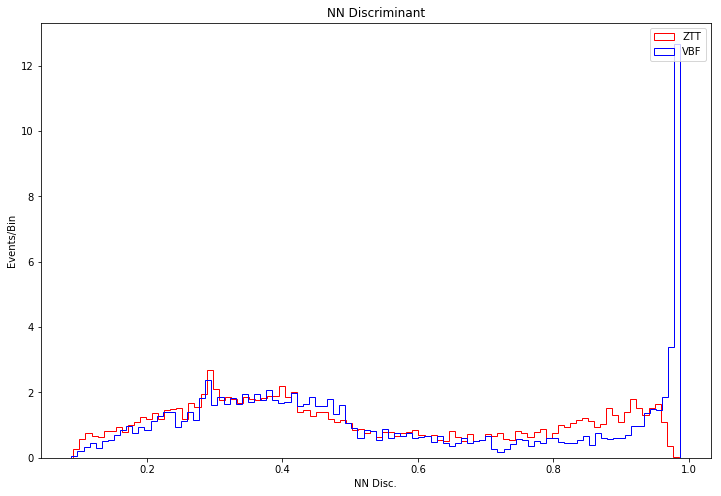

In [119]:
## define the function for making plots of the NN discriminat value
def discPlot(model, sig, bkg):
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import StandardScaler
    sig = sig.values[:, 0:6]
    bkg = bkg.values[:, 0:6]

    sig = StandardScaler().fit_transform(sig)
    bkg = StandardScaler().fit_transform(bkg)

    sig_pred = model.predict(sig)
    bkg_pred = model.predict(bkg)

    plt.figure(figsize=(12, 8))
    plt.title('NN Discriminant')
    plt.xlabel('NN Disc.')
    plt.ylabel('Events/Bin')
    plt.hist(bkg_pred, histtype='step', color='red', label='ZTT', bins=100, density=True)
    plt.hist(sig_pred, histtype='step', color='blue', label='VBF', bins=100, density=True)
    plt.legend()
discPlot(model, signal, tt_bkg_df)

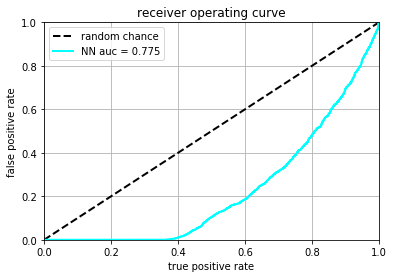

In [123]:
%matplotlib inline
import matplotlib.pyplot as plt
## define the function for plotting ROC curves
def ROC_curve(data_test, label_test, weights, model):
    from sklearn.metrics import roc_curve, auc

    label_predict = model.model.predict(data_test) ## use the model to do classifications
    fpr, tpr, _ = roc_curve(
        label_test, label_predict[:, 0], sample_weight=weights) ## calculate the ROC curve
    roc_auc = auc(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2,
             color='k', label='random chance')
    plt.plot(tpr, fpr, lw=2, color='cyan', label='NN auc = %.3f' % (roc_auc))
    plt.xlim([0, 1.0])
    plt.ylim([0, 1.0])
    plt.xlabel('true positive rate')
    plt.ylabel('false positive rate')
    plt.title('receiver operating curve')
    plt.legend(loc="upper left")
    plt.grid()
## make some pretty plots
ROC_curve(data,
              label,
              weight,
              model
              )